In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  3 19:17:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install pysurvival

     |████████████████████████████████| 4.7 MB 3.1 MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773294 sha256=5638bd4de390b4236a6bde4f43507248ecdd453adda52e51969e804f2558e225
  Stored in directory: /root/.cache/pip/wheels/1a/63/e2/32273d765a4e2f4ccac69c8adf97425ca80bab5d0c8447f120
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=ac9e360cfc34486faf1670e800a9930ec6f571e3558fbe0651b52b8d427fb61a
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built pysurvival progressbar


In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sklearn.model_selection import StratifiedKFold

In [8]:
np.random.RandomState(666)
df = pd.read_excel('partdata.xlsx')

In [13]:
df_new = df.dropna()
print(df_new.head(5))

    time  status    col1    col2   col3  ...   col21  col22  col23  col24  col25
0  261.0       0  2117.0  1281.0  666.0  ...  8645.0  696.0  377.0  148.0  134.0
1  343.0       0  2036.0  2031.0  379.0  ...  8625.0  581.0  548.0  153.0   92.0
2   22.0       1  2117.0  1281.0  666.0  ...  8645.0  696.0  377.0  148.0  134.0
3   27.0       1  2327.0  1457.0  585.0  ...  8664.0  741.0  386.0  118.0   91.0
4   66.0       1  2327.0  1457.0  585.0  ...  8664.0  741.0  386.0  118.0   91.0

[5 rows x 27 columns]


In [30]:
X = df_new.iloc[:,2:]
y = df_new[['status','time']]

In [48]:
df_status0 = df_new[df_new['status']==0]
df_status1= df_new[df_new['status']==1]
print(df_status0.shape[0])
print(df_status1.shape[0])
index_0 = int(df_status0.shape[0]/10)
index_1 = int(df_status1.shape[0]/10)
df_sub_status0 = df_status0.loc[np.random.choice(df_status0.index, index_0, replace=False)]
df_sub_status1 = df_status1.loc[np.random.choice(df_status1.index, index_1, replace=False)]



76953
24036


In [56]:
df_sub = pd.concat([df_sub_status0,df_sub_status1])
print(df_sub.head(5))
# shuffle the rows
df_sub_new = df_sub.sample(frac=1).reset_index(drop=True)
print(df_sub_new.head(5))

        time  status    col1    col2  ...   col22  col23  col24  col25
12641   71.0       0  2318.0  1488.0  ...   720.0   84.0  272.0   97.0
34611  302.0       0  2073.0  1246.0  ...  1190.0  193.0  360.0  155.0
42922  309.0       0  3452.0   725.0  ...  1233.0  297.0  424.0  126.0
35621  232.0       0  1760.0  2744.0  ...   857.0  223.0  320.0   43.0
48861   76.0       0  2766.0   887.0  ...   612.0  307.0  265.0   72.0

[5 rows x 27 columns]
    time  status    col1    col2    col3  ...   col21   col22  col23  col24  col25
0  145.0       0  2912.0  1185.0   215.0  ...  7967.0   864.0  562.0  576.0   31.0
1  113.0       0  2250.0  1252.0  1288.0  ...  8860.0   852.0  111.0  100.0   77.0
2  164.0       0  2606.0  1346.0   926.0  ...  8587.0   867.0  380.0  113.0   53.0
3  181.0       0  2705.0  1062.0   932.0  ...  8546.0   876.0  402.0  126.0   51.0
4  145.0       0  2397.0  1438.0   452.0  ...  8636.0  1000.0  200.0  115.0   49.0

[5 rows x 27 columns]


In [57]:
N = df_sub_new.shape[0]

In [58]:
# Defining the features
features = df_sub_new.columns[2:]

# Building training and testing sets #
index_train, index_test = train_test_split( range(N), test_size = 0.2)
data_train = df_sub_new.iloc[index_train].reset_index( drop = True )
data_test  = df_sub_new.iloc[index_test].reset_index( drop = True )

In [59]:
# Creating the X, T and E input
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['status'].values, data_test['status'].values

In [60]:
#### 4 - Creating an instance of the Conditional model and fitting the data.
# Building the model
rsf = RandomSurvivalForestModel(num_trees=200)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

RandomSurvivalForestModel

In [63]:
rsf.variable_importance
rsf.variable_importance_table

,feature,importance,pct_importance
0,col10,5.958535,0.064988
1,col21,5.895842,0.064304
2,col16,5.841754,0.063714
3,col4,5.168172,0.056368
4,col24,5.059488,0.055182
5,col14,4.647867,0.050693
6,col19,4.570060,0.049844
7,col13,4.202935,0.045840
8,col25,4.006965,0.043703
9,col22,3.832275,0.041797


C-index: 0.51


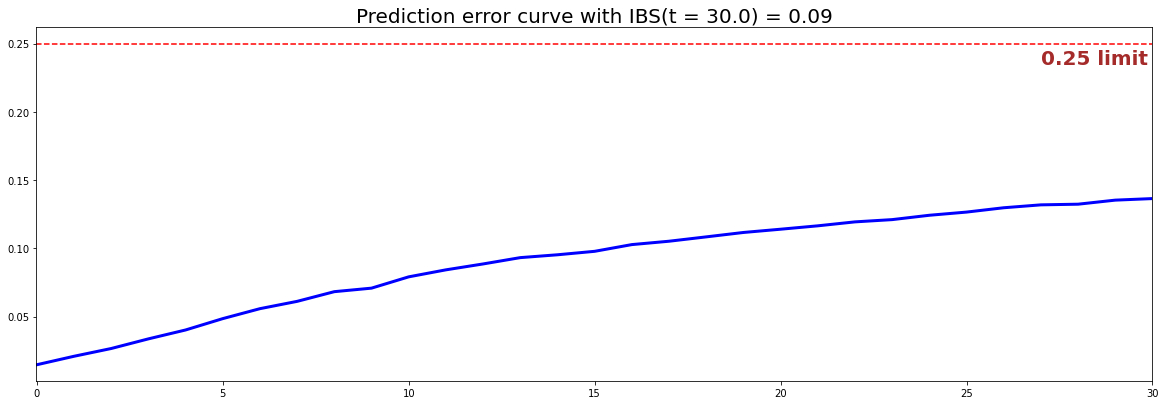

IBS: 0.09


In [61]:
#### 5 - Cross Validation / Model Performances
c_index = concordance_index(rsf, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(rsf, X_test, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

Reference: 
1. https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

2. https://square.github.io/pysurvival/models/random_survival_forest.html

Debug for data preparation: 
1. https://github.com/sebp/scikit-survival/issues/40

2. https://stackoverflow.com/questions/68869020/valueerror-y-must-be-a-structured-array-with-the-first-field-being-a-binary-cla